# Introdução

## 📘 Sobre este Estudo

Este notebook foi elaborado com fins **didáticos e demonstrativos** para mostrar como aplicar técnicas de **inferência estatística**, utilizando tanto métodos **clássicos (paramétricos)** quanto **computacionais** (como bootstrap e testes de aleatorização).

---

## 🛒 Contexto do Problema

A empresa fictícia **RetailX**, uma varejista digital, lançou uma campanha para testar o impacto de diferentes estratégias promocionais sobre o comportamento de seus clientes. A empresa está especialmente interessada em entender:

- Se as campanhas aumentam o engajamento no site
- Se as campanhas influenciam a taxa de conversão (compra)
- Se há impacto no valor total gasto

Para isso, um experimento foi conduzido com **quatro grupos de clientes**, atribuídos aleatoriamente.

---

## 🎯 Objetivo do Estudo

Avaliar se **diferentes tipos de campanha** geram **diferenças estatisticamente significativas** em:
- Taxa de conversão (realizou compra ou não)
- Valor de compra (gasto em reais)
- Número de visitas ao site (antes e depois da campanha)
---

## 🧾 Descrição das Variáveis

| Variável            | Tipo        | Descrição                                                                 |
|---------------------|-------------|---------------------------------------------------------------------------|
| `grupo`             | Categórica  | **Campanha recebida pelo cliente**:<br>• `A`: grupo **controle** (não recebeu estímulo)<br>• `B`: cupom de desconto<br>• `C`: frete grátis<br>• `D`: cashback |
| `evento`            | Binária     | Indicador de conversão: o cliente **realizou uma compra?** (`1` = sim, `0` = não) |
| `score`             | Contínua    | Valor total gasto pelo cliente (em reais) durante o período da campanha  |
| `pre_treinamento`   | Contínua    | Número de visitas ao site **antes da campanha**                           |
| `pos_treinamento`   | Contínua    | Número de visitas ao site **após a campanha**                             |

---

## 🧠 O que significa “grupo controle”?

O grupo **controle** (`grupo = A`) é formado por clientes que **não receberam nenhuma campanha promocional**. Esse grupo serve como **referência neutra**, permitindo que possamos comparar com os demais grupos e **isolar o efeito da campanha**.

> Exemplo: Se o grupo B (cupom) tiver maior conversão do que o grupo A (controle), é possível afirmar com maior confiança que o cupom teve impacto real — desde que a diferença seja estatisticamente significativa.

---

## ✅ Instruções de Análise

Para cada uma das perguntas a seguir, faça quando aplicável:

1. **Construa um intervalo de confiança de 95% para estimar a variabilidade da estatística obtida.**  
2. **Interprete corretamente o intervalo de confiança obtido** e o que ele indica sobre a estimativa.  
3. **Formule as hipóteses nula (H₀) e alternativa (Hₐ)** com base no problema proposto.  
4. **Escolha o teste estatístico adequado**, considerando se o método será paramétrico ou computacional.  
5. **Calcule a estatística de teste e o valor-p correspondente**, adotando um nível de significância de 5%.  
6. **Analise o resultado no contexto de negócios:** o efeito observado parece real ou pode ser atribuído ao acaso?

---


# Análises

In [1]:
# SETUP
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, t, f

In [2]:
# LOAD: A base já está sanitizada.
base = pd.read_excel("dados/base_retailx.xlsx")
base.head()

,grupo,evento,score,pre_treinamento,pos_treinamento
0,A,0,0.00,6,6
1,A,1,70.68,4,4
2,A,1,60.23,6,6
3,A,1,102.16,8,8
4,A,0,0.00,1,2


In [3]:
# Quantidade de amostras
base.shape[0]

300

## 🔹 1. Intervalo de Confiança para Proporção

> Construa um intervalo de confiança de 95% para estimar a proporção de clientes que realizaram compra.

In [4]:
# Amostra
X = base["evento"].values

# Tamanho da amostra
n = X.shape[0] 

# Proporção observada de clientes que realizaram alguma compra
p_obs = X.mean()
print(f"p_obs = {np.round(p_obs,2)}")

p_obs = 0.57


### 💻 Computacional

**Bootstrap:**

Técnica utilizada para estimar a variabilidade de uma estatística, a partir da distribuição amostral da estatística obtida via reamostragem com reposição sobre uma única amostra disponível.
A distribuição bootstrap é centrada na estatística observada na amostra original e permite, por exemplo, a construção de intervalos de confiança e avaliação da incerteza da estimativa.

In [5]:
# BOOTSTRAP

# Reamostragem
n_simu = 10_000 # 10 mil simulações
stat_dist = []

for _ in range(n_simu):

    # Reamostra com reposição
    X_boot = np.random.choice(X, size=n, replace=True)

    # Estatistica
    p_boot = X_boot.mean()
    stat_dist.append(p_boot)


# Calcular os percentis
gama = 95
stat_dist = np.array(stat_dist)
percentile_l = np.percentile(stat_dist, (100 - gama)/2)
percentile_r = np.percentile(stat_dist, gama + (100 - gama)/2)

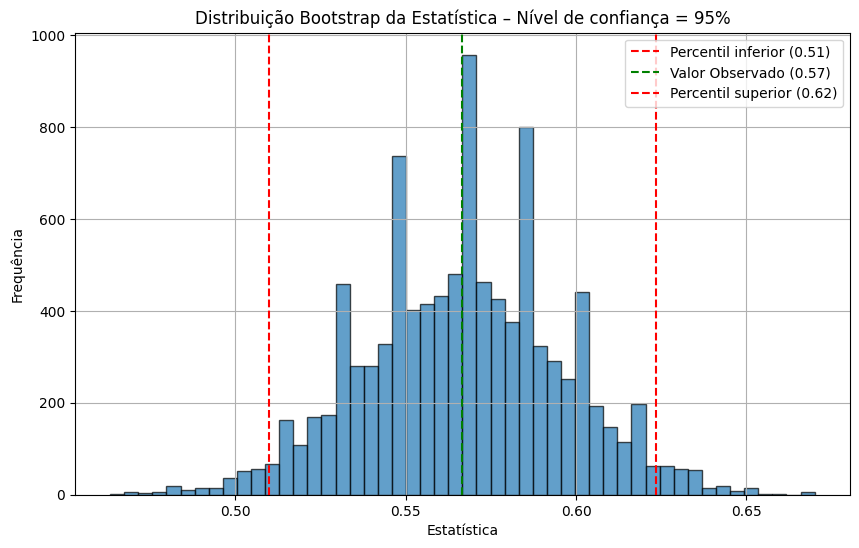

IC_95 = [0.51: 0.623]


In [6]:
# Plotar histograma da distribuição bootstrap
plt.figure(figsize=(10, 6))
plt.hist(stat_dist, bins=50, edgecolor='black', alpha=0.7)

# Linhas 
plt.axvline(percentile_l, color='red', linestyle='--', label=f'Percentil inferior ({percentile_l:.2f})') # Percentil inferior
plt.axvline(p_obs, color='green', linestyle='--', label=f'Valor Observado ({p_obs:.2f})')                # Valor observado
plt.axvline(percentile_r, color='red', linestyle='--', label=f'Percentil superior ({percentile_r:.2f})') # Percentil superior

# Título e rótulos
plt.title(f'Distribuição Bootstrap da Estatística – Nível de confiança = {gama}%')
plt.xlabel('Estatística')
plt.ylabel('Frequência')
plt.legend()
plt.grid(True)
plt.show()
print(f"IC_95 = [{np.round(percentile_l, 3)}: {np.round(percentile_r, 3)}]")

**Interpretação do Intervalo obtido:**
- Podemos afirmar com 95% de confiança que o verdadeiro valor do parâmetro populacional está entre os percentis inferior e superior do intervalo de confiança construído, conforme indicado no histograma acima.

- Importante: essa confiança não deve ser interpretada como a probabilidade de o parâmetro estar dentro deste intervalo específico, mas sim da seguinte forma:
    > Se este mesmo experimento (coletar outras amostras sob as mesmas condições) fosse repetido muitas vezes, e em cada repetição fosse construído um intervalo de confiança da mesma forma, então aproximadamente 95% desses intervalos conteriam o verdadeiro valor do parâmetro populacional.
    > Portanto, com base na confiança que temos no processo de construção do intervalo, estamos 95% confiantes de que este intervalo específico contém o valor verdadeiro do parâmetro.

### 📊 Modelo Estatístico

Suposições que devem ser atendidas:
- A variável observada é binária.
- Cada observação é independente e igualmente distribuída (i.i.d).
    - O valor de uma observação não influência na outra.
    - Probabilidade de sucesso é constante.
- O número de observações (n) é fixo e conhecido.
- Podemos aproximar a disitribuição amostral pela normal através do TCL (Teorema Central do Limite) quando:
    - np >= 10 
    - n(1-p) >=10

Deduções:

<img src="img/1.dist_proporcao.jpeg" width="500">
<img src="img/2.ic_proporcao.jpeg" width="500">


In [7]:
# Melhor estimativa para p
p = p_obs      

# Avaliando condições para aproximar pela normal
print(f"np = {n*p} >= 10 OK")
print(f"n(1-p) = {n*(1-p)} >= 10 OK")

np = 170.0 >= 10 OK
n(1-p) = 130.0 >= 10 OK


In [8]:
# Obtendo o erro padrão da estatística (desvio padrão da distribuição da estatística)
SE = np.sqrt(p*(1-p)/n)
print(f"SE = {SE}")

SE = 0.02860976264351941


In [9]:
# Obtendo valor crítico na distribuição normal padrão
Zc = norm.ppf(0.975)
print(f"Zc = {Zc}")

Zc = 1.959963984540054


In [10]:
# Obtendo o IC
p0 = p - Zc*SE
p1 = p + Zc*SE
print(f"IC_95 = [{np.round(p0, 2)}: {np.round(p1, 2)}]")

IC_95 = [0.51: 0.62]


In [11]:
# Obtendo o IC sem usar a padronização
print(f"IC_95 = [{np.round(norm.ppf(0.025, loc=p, scale=SE), 2)}: {np.round(norm.ppf(0.975, loc = p, scale=SE), 2)}]")

IC_95 = [0.51: 0.62]


O que fizemos foi selecionar 95% dos dados centrais da distribuição amostral da estatística de interesse, a qual foi aproximada por uma distribuição normal, centrada em p_obs.

## 🔹 2. Teste de Hipótese para Proporção

> A taxa de conversão geral (proporção de clientes que compraram) é maior que 50%?

🧪 Hipóteses do Teste

- H₀:  A taxa de conversão **não é maior** que 50%. O valor observado de 57% seria, nesse caso, apenas fruto do acaso.  
- Hₐ: A taxa de conversão **é maior** que 50%.  

Formalmente:
- H₀: *p* = 50%
- Hₐ: *p* > 50%

O teste consiste em avaliar **quão provável seria observar um valor tão extremo quanto p_obs = 57%**, assumindo que a hipótese nula (H₀: *p* = 50%) seja verdadeira.


### 💻 Computacional

**Bootstrap:**

Assumindo a hipótese nula (H₀) como verdadeira — ou seja, que a proporção populacional é *p* = 50%:

- Coletamos uma amostra aleatória de tamanho *n* = 300 elementos e proporção amostral igual a 50%.  
- A partir dessa amostra representativa da população com *p* = 50%, aplicamos o método de **bootstrap** para gerar uma distribuição amostral da proporção.  
- Essa distribuição reflete a **variabilidade da proporção amostral esperada apenas pelo acaso**, sob a suposição de que H₀ é verdadeira.


In [12]:
# BOOTSTRAP

# Reamostragem
n_simu = 10_000 # 10 mil simulações
stat_dist = []

for _ in range(n_simu):

    # Reamostra com reposição
    X_boot = np.random.choice(np.array([0]*150 + [1]*150), size=n, replace=True)

    # Estatistica
    p_boot = X_boot.mean()
    stat_dist.append(p_boot)


# Calcular os percentis
alpha = 0.05
gama = 1 - alpha
stat_dist = np.array(stat_dist)
percentile_l = np.percentile(stat_dist, (100 - gama)/2)
percentile_r = np.percentile(stat_dist, gama + (100 - gama)/2)

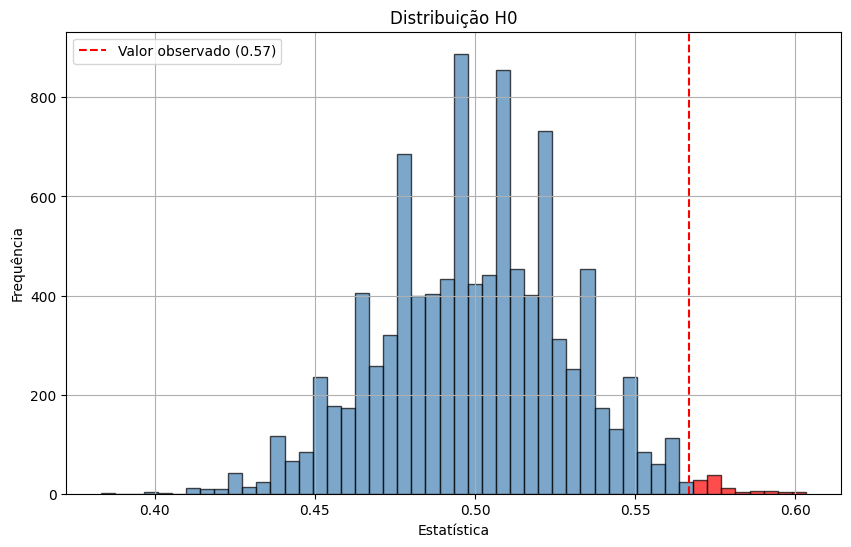

In [13]:
# Ponto de corte
limite = p_obs

# Criar histograma manualmente
counts, bins = np.histogram(stat_dist, bins=50)
bin_centers = 0.5 * (bins[1:] + bins[:-1])

# Definir cores com base no limite
cores = ['red' if centro > limite else 'steelblue' for centro in bin_centers]

# Plotar
plt.figure(figsize=(10, 6))
plt.bar(bin_centers, counts, width=(bins[1] - bins[0]), color=cores, edgecolor='black', alpha=0.7)

# Linha vertical no valor observado
plt.axvline(p_obs, color='red', linestyle='--', label=f'Valor observado ({p_obs:.2f})')

# Título e rótulos
plt.title(f'Distribuição H0')
plt.xlabel('Estatística')
plt.ylabel('Frequência')
plt.legend()
plt.grid(True)
plt.show()


In [14]:
# Corresponde a área em vermelho do histograma e representa a probabilidade do acaso gerar um valor igual ou mais extremo do que o observado
p_value = (stat_dist >= p_obs).sum() / stat_dist.shape[0]

print(f"p_value = {np.round(p_value , 2)}")
print(f"alpha = {np.round(alpha , 2)}")
if p_value <= alpha:
    print(">>> Temos evidências para rejeitar H0 em favor de Ha, pois p_value <= alpha")
else:
    print(">>> Não temos evidências para rejeitar H0, pois p_value > alpha")

p_value = 0.01
alpha = 0.05
>>> Temos evidências para rejeitar H0 em favor de Ha, pois p_value <= alpha


**Interpretação do Teste de Hipótese**

Ao nível de significância de 5% (isto é, assumindo uma probabilidade de 5% de rejeitarmos H₀ incorretamente), podemos rejeitar H₀ em favor de Hₐ.
Isso significa que há evidências estatísticas para concluir que a taxa de conversão na população é superior a 50%.

### 📊 Modelo Estatístico



Assumindo a hipótese nula (H₀) como verdadeira — ou seja, que a proporção populacional é *p* = 50%, podemos construir a distribuição sob H₀ da seguinte forma:

- Se realizássemos várias amostragens aleatórias de tamanho *n* = 300 a partir de uma população com proporção *p* = 50%, e construíssemos a distribuição dessas proporções amostrais, o Teorema Central do Limite (TCL) afirma que, se *n* for suficientemente grande, essa distribuição será aproximadamente normal.

**Condições para aplicar o TCL no caso de proporções:**
- *np* > 10  
- *n(1 − p)* > 10

Essas condições garantem que a distribuição amostral da proporção seja bem aproximada por uma distribuição normal.


In [15]:
# Sabemos o valor de p
p = 0.5      

# Avaliando condições para aproximar pela normal
print(f"np = {n*p} >= 10 OK")
print(f"n(1-p) = {n*(1-p)} >= 10 OK")

np = 150.0 >= 10 OK
n(1-p) = 150.0 >= 10 OK


In [16]:
# Padronizando o valor observado para pegar o correspondente na distribuição normal padrão
SE = np.sqrt(p*(1-p)/n)
Z_obs = (p_obs - p)/SE

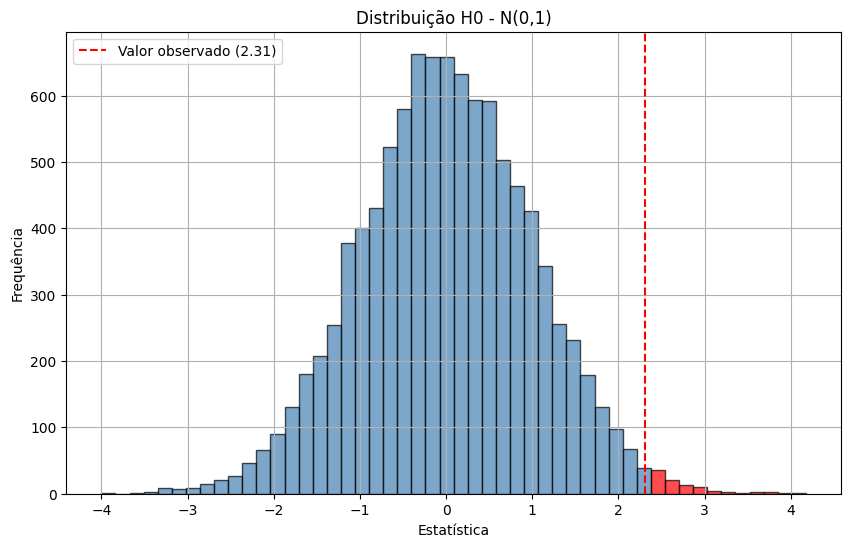

In [17]:
# REPRESENTAÇÃO GRÁFICA - opcional

# Ponto de corte
limite = Z_obs

stat_dist = norm.rvs(loc=0, scale=1, size=10_000)

# Criar histograma manualmente
counts, bins = np.histogram(stat_dist, bins=50)
bin_centers = 0.5 * (bins[1:] + bins[:-1])

# Definir cores com base no limite
cores = ['red' if centro > limite else 'steelblue' for centro in bin_centers]

# Plotar
plt.figure(figsize=(10, 6))
plt.bar(bin_centers, counts, width=(bins[1] - bins[0]), color=cores, edgecolor='black', alpha=0.7)

# Linha vertical no valor observado
plt.axvline(Z_obs, color='red', linestyle='--', label=f'Valor observado ({Z_obs:.2f})')

# Título e rótulos
plt.title(f'Distribuição H0 - N(0,1)')
plt.xlabel('Estatística')
plt.ylabel('Frequência')
plt.legend()
plt.grid(True)
plt.show()


In [18]:
# Corresponde a área em vermelho do histograma e representa a probabilidade do acaso gerar um valor igual ou mais extremo do que o observado
# p_value = P(Z >= Z_obs)
p_value = 1 - norm.cdf(Z_obs, loc = 0, scale = 1)

print(f"p_value = {np.round(p_value , 2)}")
print(f"alpha = {np.round(alpha , 2)}")
if p_value <= alpha:
    print(">>> Temos evidências para rejeitar H0 em favor de Ha, pois p_value <= alpha")
else:
    print(">>> Não temos evidências para rejeitar H0, pois p_value > alpha")

p_value = 0.01
alpha = 0.05
>>> Temos evidências para rejeitar H0 em favor de Ha, pois p_value <= alpha


## 🔹 3. Intervalo de Confiança para Diferença entre Proporções (grupos D e B)

> Construa um intervalo de confiança de 95% para estimar a diferença na taxa de conversão entre os grupos D e B.

In [19]:
# Amostra B
c = base["grupo"] == "B"
XB = base.loc[c, "evento"].values

# Tamanho da amostra
nB = XB.shape[0]

# Proporção observada de clientes que realizaram alguma compra no grupo B
p_obs_B = XB.mean()

print(f"nB = {nB}")
print(f"p_obs_B = {np.round(p_obs_B,2)}")

nB = 75
p_obs_B = 0.63


In [20]:
# Amostra D
c = base["grupo"] == "D"
XD = base.loc[c, "evento"].values

# Tamanho da amostra
nD = XD.shape[0]

# Proporção observada de clientes que realizaram alguma compra no grupo D
p_obs_D = XD.mean()

print(f"nD = {nD}")
print(f"p_obs_D = {np.round(p_obs_D,2)}")

nD = 75
p_obs_D = 0.61


In [21]:
# Diferença observada
diff_obs = p_obs_B - p_obs_D
print(f"diff_obs = {diff_obs}")

diff_obs = 0.01333333333333342


### 💻 Computacional

**Bootstrap:**

Utilizamos o método de bootstrap separadamente para cada grupo e, em cada iteração, calculamos a estatística de interesse — que, neste caso, é a diferença entre as proporções dos grupos B e D.

In [22]:
# BOOTSTRAP

# Reamostragem
n_simu = 10_000 # 10 mil simulações
stat_dist = []

for _ in range(n_simu):

    # Reamostra com reposição
    X_boot_B = np.random.choice(XB, size=nB, replace=True)
    X_boot_D = np.random.choice(XD, size=nD, replace=True)

    # Estatistica
    p_boot_B = X_boot_B.mean()
    p_boot_D = X_boot_D.mean()
    stat_dist.append(p_boot_B - p_boot_D)


# Calcular os percentis
gama = 95
stat_dist = np.array(stat_dist)
percentile_l = np.percentile(stat_dist, (100 - gama)/2)
percentile_r = np.percentile(stat_dist, gama + (100 - gama)/2)

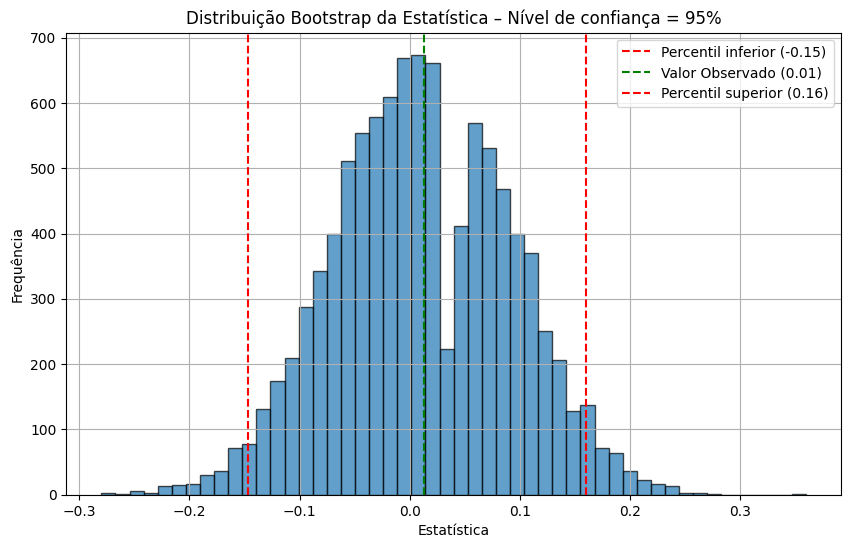

IC_95 = [-0.147: 0.16]


In [23]:
# Plotar histograma da distribuição bootstrap
plt.figure(figsize=(10, 6))
plt.hist(stat_dist, bins=50, edgecolor='black', alpha=0.7)

# Linhas 
plt.axvline(percentile_l, color='red', linestyle='--', label=f'Percentil inferior ({percentile_l:.2f})') # Percentil inferior
plt.axvline(diff_obs, color='green', linestyle='--', label=f'Valor Observado ({diff_obs:.2f})')                # Valor observado
plt.axvline(percentile_r, color='red', linestyle='--', label=f'Percentil superior ({percentile_r:.2f})') # Percentil superior

# Título e rótulos
plt.title(f'Distribuição Bootstrap da Estatística – Nível de confiança = {gama}%')
plt.xlabel('Estatística')
plt.ylabel('Frequência')
plt.legend()
plt.grid(True)
plt.show()
print(f"IC_95 = [{np.round(percentile_l, 3)}: {np.round(percentile_r, 3)}]")

**Interpretação do Intervalo obtido:**
- Podemos afirmar com 95% de confiança que o verdadeiro valor do parâmetro populacional está entre os percentis inferior e superior do intervalo de confiança construído, conforme indicado acima.

### 📊 Modelo Estatístico

Suposições que devem ser atendidas:
- Dentro de cada grupo, deve atender as mesmas suposições estabelecidas em **1. Modelo Estatístico**.
- Os grupos devem ser independentes.


Deduções:

<img src="img/3.dist_proporcao_diff.jpeg" width="500">
<img src="img/4.ic_proporcao_diff.jpeg" width="500">

In [24]:
# Melhor estimativa para p1
p1 = p_obs_B
n1 = nB
# Avaliando condições para aproximar pela normal
print(f"n1p1 = {n1*p1} >= 10 OK")
print(f"n1(1-p1) = {n1*(1-p1)} >= 10 OK")

n1p1 = 47.0 >= 10 OK
n1(1-p1) = 27.999999999999996 >= 10 OK


In [25]:
# Melhor estimativa para p2
p2 = p_obs_D
n2 = nD
# Avaliando condições para aproximar pela normal
print(f"n2p2 = {n2*p2} >= 10 OK")
print(f"n2(2-p2) = {n2*(1-p2)} >= 10 OK")

n2p2 = 46.0 >= 10 OK
n2(2-p2) = 29.000000000000004 >= 10 OK


In [26]:
# Obtendo o erro padrão da estatística (desvio padrão da distribuição da estatística)
SE = np.sqrt(p1*(1-p1)/n1 + p2*(1-p2)/n2)
print(f"SE = {SE}")

SE = 0.07925579777834225


In [27]:
# Obtendo valor crítico na distribuição normal padrão
Zc = norm.ppf(0.975)
print(f"Zc = {Zc}")

Zc = 1.959963984540054


In [28]:
# Obtendo o IC
d0 = (p1 - p2) - Zc*SE
d1 = (p1 - p2) + Zc*SE
print(f"IC_95 = [{np.round(d0, 3)}: {np.round(d1, 3)}]")

IC_95 = [-0.142: 0.169]


## 🔹 4. Teste de Hipótese para Diferença entre Proporções

> A taxa de conversão no grupo B (cupom de desconto) é diferente do que no grupo D (cashback) ?

🧪 Hipóteses do Teste

- H₀: Não há diferença na taxa de conversão entre os grupos B e D. Qualquer diferença observada seria atribuída apenas ao acaso.
- Hₐ : Existe uma diferença na taxa de conversão entre os grupos B e D.

Formalmente:
- H₀: *p₁ − p₂* = 0  
- Hₐ: *p₁ − p₂* ≠ 0

O teste consiste em avaliar **quão provável seria observar uma diferença tão extrema quanto a observada (*p_obs_B − p_obs_D*)**, assumindo que a hipótese nula seja verdadeira.

### 💻 Computacional

**Randomization Test**

Técnica utilizada para simular um cenário em que **não há diferença entre as duas populações** — ou seja, sob a hipótese nula (H₀).

A ideia é **quebrar o efeito dos grupos**, removendo qualquer associação real entre o grupo (B ou D) e a resposta (por exemplo, se houve ou não compra). Para isso:

- Mantemos a amostra original, mas **embaralhamos aleatoriamente as respostas** entre os indivíduos dos dois grupos.
- Em seguida, **reconstruímos dois grupos artificiais**:
  - Um com o mesmo tamanho do grupo B
  - Outro com o mesmo tamanho do grupo D
- Calculamos a estatística de interesse (por exemplo, a diferença entre as proporções de conversão) para essa nova divisão aleatória.
- Repetimos esse processo muitas vezes, gerando uma **distribuição amostral da estatística sob H₀** — ou seja, sob o cenário em que **a diferença entre os grupos é nula**.

Ao embaralhar as respostas, estamos simulando um mundo onde **o grupo não influencia o resultado**. Isso nos permite avaliar **quão extrema é a estatística observada**, comparada ao que esperaríamos **apenas pelo acaso**.


In [29]:
# RANDOMIZATION TEST

# Reamostragem
n_simu = 10_000
stat_dist = []

for _ in range(n_simu):

    # Embaralha
    shuffled = np.random.permutation(np.concatenate([XB, XD]))

    # Proporções
    pseudo_group_B = shuffled[:nB]
    pseudo_group_D = shuffled[nD:]

    # Estatistica
    stat_dist.append(pseudo_group_B.mean() - pseudo_group_D.mean())

stat_dist = np.array(stat_dist)

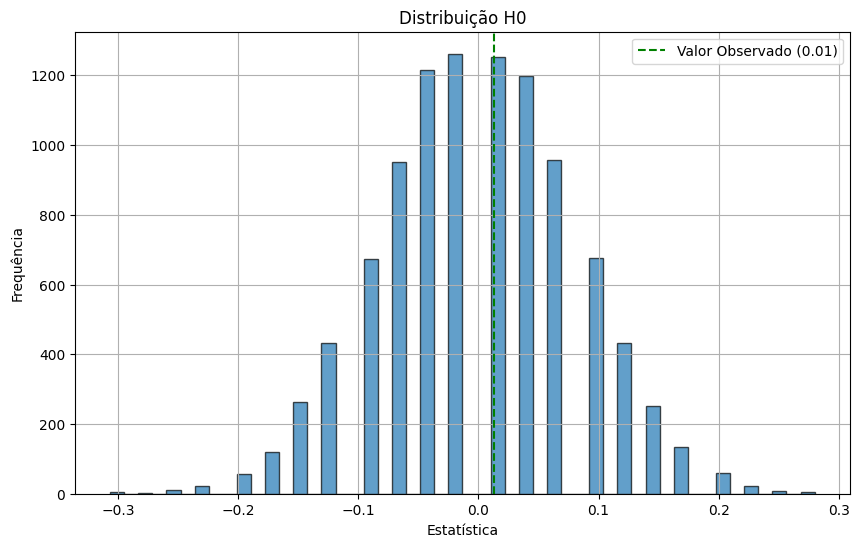

In [30]:
# Plotar histograma da distribuição H0
plt.figure(figsize=(10, 6))
plt.hist(stat_dist, bins=50, edgecolor='black', alpha=0.7)

# Linhas 
plt.axvline(diff_obs, color='green', linestyle='--', label=f'Valor Observado ({diff_obs:.2f})')

# Título e rótulos
plt.title(f'Distribuição H0')
plt.xlabel('Estatística')
plt.ylabel('Frequência')
plt.legend()
plt.grid(True)
plt.show()

In [31]:
p_value = (np.abs(stat_dist) >= np.abs(diff_obs)).sum() / stat_dist.shape[0]

print(f"p_value = {np.round(p_value , 2)}")
print(f"alpha = {np.round(alpha , 2)}")
if p_value <= alpha:
    print(">>> Temos evidências para rejeitar H0 em favor de Ha, pois p_value <= alpha")
else:
    print(">>> Não temos evidências para rejeitar H0, pois p_value > alpha")

p_value = 1.0
alpha = 0.05
>>> Não temos evidências para rejeitar H0, pois p_value > alpha


**Interpretação do Teste de Hipótese**

Não há evidências estatísticas suficientes para rejeitar a hipótese nula (H₀).  
Ou seja, o resultado obtido nesta amostra **não é suficientemente significativo** para concluirmos que as taxas de conversão dos grupos B e D são, de fato, diferentes na população.

### 📊 Modelo Estatístico



descrever a idea do teste de hipótese

In [32]:
# Melhor estimativa para p1 e p2 é p0
p0 = (n1*p1 + n2*p2)/(n1+n2)
p1 = p2 = p0

# Avaliando condições para aproximar pela normal
print(f"n1p1 = {n1*p1} >= 10 OK")
print(f"n1(1-p1) = {n1*(1-p1)} >= 10 OK")
print(f"n2p2 = {n2*p2} >= 10 OK")
print(f"n2(2-p2) = {n2*(1-p2)} >= 10 OK")

n1p1 = 46.5 >= 10 OK
n1(1-p1) = 28.5 >= 10 OK
n2p2 = 46.5 >= 10 OK
n2(2-p2) = 28.5 >= 10 OK


In [33]:
# Obtendo o erro padrão da estatística (desvio padrão da distribuição da estatística)
SE = np.sqrt(p1*(1-p1)/n1 + p2*(1-p2)/n2)
print(f"SE = {SE}")

SE = 0.0792632743877432


In [34]:
Z_obs = (diff_obs - 0)/SE
Z_obs

0.16821577756312334

In [35]:
# p_value = P(Z >= Z_obs) + P(Z <= -Z_obs)
p_value = 1 - norm.cdf(Z_obs, loc = 0, scale = 1) + norm.cdf(-Z_obs, loc = 0, scale = 1)

print(f"p_value = {np.round(p_value , 2)}")
print(f"alpha = {np.round(alpha , 2)}")
if p_value <= alpha:
    print(">>> Temos evidências para rejeitar H0 em favor de Ha, pois p_value <= alpha")
else:
    print(">>> Não temos evidências para rejeitar H0, pois p_value > alpha")

p_value = 0.87
alpha = 0.05
>>> Não temos evidências para rejeitar H0, pois p_value > alpha


## 🔹 5. Associação entre variáveis categóricas

> A taxa de conversão (`evento`) está associada ao tipo de campanha (`grupo`)?

## 🔹 6. Intervalo de Confiança para a Média Geral de Compras

> Construa um intervalo de confiança de 95% para estimar o valor médio de compra (`score`) de todos os clientes.

## 🔹 7. Teste de Hipótese para uma Média

> O valor médio de compra (`score`) de todos os clientes é maior que R$ 70?

## 🔹 8. Intervalo de Confiança para Diferença entre Médias (D vs. B)

> Construa um intervalo de confiança de 95% para estimar a diferença no valor médio de compra entre os grupos D e B.

## 🔹 9. Teste de Hipótese para Diferença entre Médias

> O grupo D gerou um valor médio de compra diferente do que o grupo B?

## 🔹 10. Intervalo de Confiança para Diferença de Médias Pareadas

> Construa um intervalo de confiança de 95% para estimar o efeito da campanha na mudança de número de visitas (antes e depois).

## 🔹 11. Teste de Hipótese para Diferença de Médias Pareadas

> A campanha aumentou o número médio de visitas ao site por cliente?

## 🔹 12. Diferença entre 4 médias (ANOVA)

> Há diferenças significativas no valor médio de compra entre os quatro grupos de campanha (A, B, C, D)?

## 🔹 13. Pós-ANOVA (quem difere de quem?)

> Quais campanhas geraram resultados estatisticamente diferentes em termos de valor médio de compra?

# Referências
- https://openintro-ims.netlify.app/inference-one-prop